# Objective:
## Train a 3D U-Net based model with Multi-Scale Attention to predict heatmaps indicating potential lung nodule location on the LUNA16 Dataset. Map predictions back to real-world coordinates.

In [18]:
import os
import sys
import time
import random
import warnings
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy for processing
from scipy.ndimage import gaussian_filter, maximum_filter, binary_dilation, generate_binary_structure
from scipy import stats
from scipy.ndimage import label as ndimage_label 
# Sklearn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast # Mixed precision

# Ignore SimpleITK warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"SimpleITK Version: {sitk.Version()}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Python Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch Version: 2.5.1+cu124
SimpleITK Version: SimpleITK Version: 2.4.1 (ITK 5.4)
Compiled: Jan  9 2025 14:33:28

NumPy Version: 1.26.4
Pandas Version: 2.2.3
GPU Available: True
GPU Name: Tesla P100-PCIE-16GB


In [20]:
LUNA16_BASE_DIR = Path("/kaggle/input/luna-16/Dataset") # Contains subset0, subset1, ..., annotations.csv
ANNOTATIONS_CSV = LUNA16_BASE_DIR / "annotations.csv"
CANDIDATES_CSV = LUNA16_BASE_DIR / "/Dataset/candidates_V2candidates_V2.csv" # Optional, but useful for evaluation/negative mining

# --- Working Directories ---
WORKING_DIR = Path("/kaggle/working/") # Where the notebook runs
PREPROCESSED_DIR = WORKING_DIR / "preprocessed_msa_unet_1mm"
RESULTS_DIR = WORKING_DIR / "results_msa_unet"
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = RESULTS_DIR / "best_model_msa_unet.pth"

In [21]:
# --- Preprocessing Parameters ---
TARGET_SPACING = np.array([1.0, 1.0, 1.0]) # Target voxel spacing in mm (z, y, x)
CLIP_BOUNDS = (-1000, 400) # HU clipping range
NORM_RANGE = (0.0, 1.0)   # Normalization range (min-max scaling)
LUNG_THRESHOLD = -320     # HU threshold for rough lung segmentation

# --- Model & Training Parameters ---
PATCH_SIZE = (96, 96, 96) # Input patch size (z, y, x) - Adjust based on GPU memory
STRIDE = (48, 48, 48)     # Stride for patch extraction during inference/full volume prediction
BATCH_SIZE = 2            # Adjust based on GPU memory
NUM_EPOCHS = 50           # Number of training epochs
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
POSITIVE_WEIGHT = 10.0    # Weight for positive class in BCE loss (adjust based on imbalance)
HEATMAP_SIGMA = 3.0       # Sigma for Gaussian heatmap generation (in voxels)
NMS_THRESHOLD = 0.1       # Threshold for NMS/peak finding
NMS_FOOTPRINT_SIZE = 5   # Size of the neighborhood for maximum_filter

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Set to False for reproducibility, True for potential speedup

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Data Splitting ---
VAL_SPLIT_RATIO = 0.1 # 10% for validation

Using device: cuda


In [22]:
def load_ct_scan(mhd_path):
    """Loads a CT scan using SimpleITK."""
    return sitk.ReadImage(str(mhd_path))

def get_scan_properties(sitk_image):
    """Extracts origin, spacing, and direction matrix."""
    origin = np.array(sitk_image.GetOrigin())     # x, y, z
    spacing = np.array(sitk_image.GetSpacing())   # x, y, z
    direction = np.array(sitk_image.GetDirection()).reshape(3, 3)
    return origin, spacing, direction

def world_to_voxel(world_coords, origin, spacing):
    """Converts world coordinates (mm) to voxel coordinates."""
    # world_coords: (x, y, z)
    # origin: (x, y, z)
    # spacing: (x, y, z)
    stretched_voxel_coords = np.absolute(world_coords - origin)
    voxel_coords = stretched_voxel_coords / spacing
    return voxel_coords # (vx, vy, vz)

def voxel_to_world(voxel_coords, origin, spacing):
    """Converts voxel coordinates to world coordinates (mm)."""
    # voxel_coords: (vx, vy, vz) or (vz, vy, vx) if using numpy indexing
    # origin: (x, y, z)
    # spacing: (x, y, z)
    if len(voxel_coords) == 3 and isinstance(voxel_coords, (np.ndarray, tuple, list)):
         # Assume numpy order (z, y, x) -> convert to (x, y, z) for calculation
        voxel_coords_xyz = np.array([voxel_coords[2], voxel_coords[1], voxel_coords[0]])
    else:
        raise ValueError("voxel_coords must be a 3-element sequence (z, y, x) or (x, y, z)")

    world_coords = (voxel_coords_xyz * spacing) + origin
    return world_coords # (x, y, z)

def resample_volume(sitk_image, target_spacing=TARGET_SPACING):
    """Resamples the volume to a target spacing."""
    original_spacing = np.array(sitk_image.GetSpacing())
    original_size = np.array(sitk_image.GetSize())

    # Calculate new size based on target spacing
    # Target spacing is Z, Y, X ; SimpleITK uses X, Y, Z
    target_spacing_sitk = target_spacing[::-1]
    new_size = original_size * (original_spacing / target_spacing_sitk)
    new_size = np.ceil(new_size).astype(np.int32)
    new_size = [int(s) for s in new_size] # SimpleITK expects Python ints

    # Create the resample filter
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputSpacing(target_spacing_sitk)
    resample_filter.SetInterpolator(sitk.sitkLinear) # Linear interpolation
    resample_filter.SetOutputOrigin(sitk_image.GetOrigin())
    resample_filter.SetOutputDirection(sitk_image.GetDirection())
    resample_filter.SetDefaultPixelValue(CLIP_BOUNDS[0]) # Pad with min HU value

    resampled_image = resample_filter.Execute(sitk_image)
    return resampled_image

def normalize_hu(volume_np, clip_bounds=CLIP_BOUNDS, norm_range=NORM_RANGE):
    """Clips HU values and normalizes to a specified range."""
    volume_np = np.clip(volume_np, clip_bounds[0], clip_bounds[1])
    # Min-Max normalization
    min_val, max_val = clip_bounds
    norm_min, norm_max = norm_range
    volume_np = (volume_np - min_val) / (max_val - min_val)
    volume_np = volume_np * (norm_max - norm_min) + norm_min
    return volume_np.astype(np.float32)

def get_lung_mask(volume_np, threshold=LUNG_THRESHOLD):
    """
    Generates a rough lung mask using thresholding and morphology.
    Corrected version using scipy.ndimage.label.
    """
    # 1. Thresholding to identify air/lung regions
    binary_image = volume_np < threshold

    # 2. Morphological closing to fill small holes within lungs
    struct = generate_binary_structure(3, 2) # Connectivity=2 for 3D
    # Increased iterations for closing might help connect lung regions better
    closed_image = binary_dilation(binary_image, structure=struct, iterations=10) # Try more iterations

    # 3. Connected components analysis
    label_map, num_features = ndimage_label(closed_image)

    # Check if any structures were found besides the background
    if num_features > 0:
        # Find the sizes of all components (label 0 is background)
        component_sizes = np.bincount(label_map.ravel())

        # Identify the background label (usually 0, but find largest component if unsure)
        # background_label = np.argmax(component_sizes) # Assume largest is background
        # A safer assumption might be that background is label 0 if it exists
        background_label = 0
        component_sizes[background_label] = 0 # Ignore background size

        # Keep top 2 largest components (usually left and right lung)
        # Check if there are enough components found besides background
        if len(component_sizes) > 1:
            sorted_labels = np.argsort(component_sizes)[::-1] # Sort by size descending

            lung_mask = np.zeros_like(label_map, dtype=bool)

            # Add the largest component (potential lung 1)
            if sorted_labels[0] != background_label and component_sizes[sorted_labels[0]] > 0:
                lung_mask[label_map == sorted_labels[0]] = True

            # Add the second largest component (potential lung 2)
            if len(sorted_labels) > 1 and sorted_labels[1] != background_label and component_sizes[sorted_labels[1]] > 0:
                 lung_mask[label_map == sorted_labels[1]] = True

            # Optional: Dilate the final mask slightly to ensure borders are included
            lung_mask = binary_dilation(lung_mask, structure=struct, iterations=5) # Dilate final mask
            return lung_mask
        else:
            # Only background or one component found, return the closed image as fallback
             print(f"Warning: Only {num_features} component(s) found after labeling (excluding background). Returning closed image mask.")
             return closed_image
    else:
        # No structures found at all after thresholding/closing
        print("Warning: No components found after labeling. Returning empty mask.")
        return np.zeros_like(volume_np, dtype=bool)

def preprocess_scan(mhd_path, target_spacing=TARGET_SPACING, clip_bounds=CLIP_BOUNDS, norm_range=NORM_RANGE, lung_threshold=LUNG_THRESHOLD):
    """Full preprocessing pipeline for a single CT scan."""
    # 1. Load Scan
    sitk_image = load_ct_scan(mhd_path)
    origin, spacing, direction = get_scan_properties(sitk_image)

    # 2. Resample
    resampled_image = resample_volume(sitk_image, target_spacing)
    resampled_origin, resampled_spacing, _ = get_scan_properties(resampled_image) # Get new properties

    # 3. Convert to NumPy array (z, y, x)
    volume_np = sitk.GetArrayFromImage(resampled_image)

    # 4. Normalize HU
    normalized_volume = normalize_hu(volume_np, clip_bounds, norm_range)

    # 5. Lung Segmentation (optional but recommended)
    # We need the original HU scale for thresholding
    volume_np_for_mask = sitk.GetArrayFromImage(resampled_image)
    lung_mask = get_lung_mask(volume_np_for_mask, lung_threshold)
    processed_volume = normalized_volume * lung_mask # Apply mask

    # Store metadata needed for coordinate conversion
    metadata = {
        'original_mhd_path': str(mhd_path),
        'original_origin': origin,
        'original_spacing': spacing,
        'original_direction': direction,
        'resampled_origin': resampled_origin,
        'resampled_spacing': resampled_spacing, # Should be close to target_spacing
        'resampled_shape_xyz': resampled_image.GetSize(), # x, y, z
        'resampled_shape_zyx': processed_volume.shape, # z, y, x
        'clip_bounds': clip_bounds,
        'norm_range': norm_range
    }

    return processed_volume, metadata

In [23]:
def run_preprocessing_on_all_scans(luna_base_dir, output_dir, force_rerun=False):
    """Iterates through LUNA16 subsets and preprocesses each scan."""
    output_dir.mkdir(parents=True, exist_ok=True)
    scan_paths = sorted(list(luna_base_dir.glob("subset0/subset*/*.mhd")))
    print(f"Found {len(scan_paths)} scans to preprocess.")

    metadata_list = []

    for mhd_path in tqdm(scan_paths, desc="Preprocessing Scans"):
        series_uid = mhd_path.stem
        output_npy_path = output_dir / f"{series_uid}_image.npy"
        output_meta_path = output_dir / f"{series_uid}_meta.npy"

        if not force_rerun and output_npy_path.exists() and output_meta_path.exists():
            # print(f"Skipping {series_uid}, already preprocessed.")
            # Load existing metadata
            try:
                metadata = np.load(output_meta_path, allow_pickle=True).item()
                metadata_list.append(metadata)
            except Exception as e:
                 print(f"Error loading metadata for {series_uid}: {e}. Reprocessing.")
                 force_rerun = True # Force reprocessing if metadata load fails

        if force_rerun or not output_npy_path.exists() or not output_meta_path.exists():
            print(f"Processing {series_uid}...")
            try:
                processed_volume, metadata = preprocess_scan(mhd_path)
                np.save(output_npy_path, processed_volume)
                np.save(output_meta_path, metadata)
                metadata_list.append(metadata)
                print(f"Saved {series_uid} with shape {processed_volume.shape}")
            except Exception as e:
                print(f"!!! ERROR processing {series_uid}: {e}")
                # Optionally remove potentially corrupted output files
                if output_npy_path.exists(): output_npy_path.unlink()
                if output_meta_path.exists(): output_meta_path.unlink()


    # Save combined metadata for easy lookup
    all_metadata_path = output_dir / "all_scan_metadata.npy"
    np.save(all_metadata_path, metadata_list)
    print(f"Preprocessing complete. Saved {len(metadata_list)} processed scans and metadata to {output_dir}")
    return metadata_list

In [24]:
run_preprocessing_on_all_scans(LUNA16_BASE_DIR, PREPROCESSED_DIR, force_rerun=False)

Found 89 scans to preprocess.


Preprocessing Scans:   0%|          | 0/89 [00:00<?, ?it/s]

Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260...
Saved 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 with shape (303, 391, 391)
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492...
Saved 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492 with shape (298, 381, 381)
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059...
Saved 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059 with shape (202, 281, 281)
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987...
Saved 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987 with shape (337, 381, 381)
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720...
Saved 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720 with shape (310, 315, 315)
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565...
Saved 1.3.6.1.4.1.14519.5.2.1.6279.6

[{'original_mhd_path': '/kaggle/input/luna-16/Dataset/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd',
  'original_origin': array([-198.100006, -195.      , -335.209991]),
  'original_spacing': array([0.76171899, 0.76171899, 2.5       ]),
  'original_direction': array([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
  'resampled_origin': array([-198.100006, -195.      , -335.209991]),
  'resampled_spacing': array([1., 1., 1.]),
  'resampled_shape_xyz': (391, 391, 303),
  'resampled_shape_zyx': (303, 391, 391),
  'clip_bounds': (-1000, 400),
  'norm_range': (0.0, 1.0)},
 {'original_mhd_path': '/kaggle/input/luna-16/Dataset/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd',
  'original_origin': array([-182.5 , -190.  , -313.75]),
  'original_spacing': array([0.74218798, 0.74218798, 2.5       ]),
  'original_direction': array([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
  'resampled_o

In [25]:
try:
    metadata_list = np.load(PREPROCESSED_DIR / "all_scan_metadata.npy", allow_pickle=True).tolist()
    print(f"Loaded metadata for {len(metadata_list)} preprocessed scans.")
    # Create a quick lookup dictionary by series UID
    metadata_dict = {Path(meta['original_mhd_path']).stem: meta for meta in metadata_list}
except FileNotFoundError:
    print("Metadata file not found. Please run the preprocessing step first.")
    metadata_list = []
    metadata_dict = {}

Loaded metadata for 89 preprocessed scans.


In [26]:
# ## 5. Dataset and DataLoader

# %%
def create_gaussian_heatmap(center_voxel, shape, sigma=HEATMAP_SIGMA):
    """Creates a 3D Gaussian heatmap centered at center_voxel."""
    # center_voxel: (z, y, x)
    # shape: (depth, height, width)
    heatmap = np.zeros(shape, dtype=np.float32)
    # Ensure center is within bounds
    center_z, center_y, center_x = center_voxel
    sz, sy, sx = shape

    if 0 <= center_z < sz and 0 <= center_y < sy and 0 <= center_x < sx:
         # Create coordinate grids
        z, y, x = np.ogrid[:sz, :sy, :sx]
        # Calculate squared distance from the center voxel
        dist_sq = (z - center_z)**2 + (y - center_y)**2 + (x - center_x)**2
        # Apply Gaussian function
        heatmap = np.exp(-dist_sq / (2.0 * sigma**2))
        # Optional: Clamp values very close to zero to avoid numerical issues if needed
        # heatmap[heatmap < np.finfo(heatmap.dtype).eps * heatmap.max()] = 0
    return heatmap

class Luna16Dataset(Dataset):
    def __init__(self, series_uids, annotations_df, metadata_dict, preprocessed_dir,
                 patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA, is_train=True, augment=False):
        self.series_uids = series_uids
        self.annotations = annotations_df
        self.metadata_dict = metadata_dict
        self.preprocessed_dir = preprocessed_dir
        self.patch_size = np.array(patch_size) # z, y, x
        self.heatmap_sigma = heatmap_sigma
        self.is_train = is_train
        self.augment = augment # Placeholder for augmentation

        self.patches_info = self._create_patch_list()

    def _create_patch_list(self):
        """Creates a list of patches to sample from, potentially balancing positive/negative."""
        patch_list = []
        print("Creating patch list...")
        for series_uid in tqdm(self.series_uids, desc="Scanning volumes for patches"):
            if series_uid not in self.metadata_dict:
                print(f"Warning: Metadata not found for {series_uid}, skipping.")
                continue

            meta = self.metadata_dict[series_uid]
            scan_shape_zyx = meta['resampled_shape_zyx']
            nodules = self.annotations[self.annotations['seriesuid'] == series_uid]

            # Convert nodule world coords to resampled voxel coords
            nodule_voxels = []
            for _, row in nodules.iterrows():
                world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
                origin = meta['resampled_origin'] # x, y, z
                spacing = meta['resampled_spacing'] # x, y, z

                # Convert world (x,y,z) to voxel (vx, vy, vz)
                voxel_coords_xyz = world_to_voxel(world_coord, origin, spacing)
                # Convert voxel (vx, vy, vz) to numpy index (vz, vy, vx)
                voxel_coords_zyx = np.round(voxel_coords_xyz[::-1]).astype(int)

                # Check bounds
                if np.all(voxel_coords_zyx >= 0) and np.all(voxel_coords_zyx < scan_shape_zyx):
                    nodule_voxels.append(voxel_coords_zyx) # Store as z, y, x

            # --- Strategy: Sample patches ---
            # 1. Center patches on nodules (positive samples)
            for nodule_center_zyx in nodule_voxels:
                 # Define patch boundaries centered around the nodule
                 # Ensure the patch stays within the volume bounds
                z_start = max(0, nodule_center_zyx[0] - self.patch_size[0] // 2)
                y_start = max(0, nodule_center_zyx[1] - self.patch_size[1] // 2)
                x_start = max(0, nodule_center_zyx[2] - self.patch_size[2] // 2)

                z_end = min(scan_shape_zyx[0], z_start + self.patch_size[0])
                y_end = min(scan_shape_zyx[1], y_start + self.patch_size[1])
                x_end = min(scan_shape_zyx[2], x_start + self.patch_size[2])

                # Adjust start if end hit the boundary
                z_start = z_end - self.patch_size[0]
                y_start = y_end - self.patch_size[1]
                x_start = x_end - self.patch_size[2]

                patch_origin_zyx = np.array([z_start, y_start, x_start])
                patch_info = {'seriesuid': series_uid, 'patch_origin_zyx': patch_origin_zyx, 'is_positive': True}
                patch_list.append(patch_info)

            # 2. Sample random patches (negative/background samples)
            # Aim for roughly equal number of positive and negative patches during training? Or more negatives?
            # Let's add roughly the same number of random patches as positive ones found in this scan
            num_random_patches = len(nodule_voxels) if self.is_train else 5 # Add fewer random for val
            for _ in range(num_random_patches * 2): # Add more random ones
                # Sample random top-left corner for the patch
                max_z_start = scan_shape_zyx[0] - self.patch_size[0]
                max_y_start = scan_shape_zyx[1] - self.patch_size[1]
                max_x_start = scan_shape_zyx[2] - self.patch_size[2]

                if max_z_start < 0 or max_y_start < 0 or max_x_start < 0: continue # Scan smaller than patch

                z_start = random.randint(0, max_z_start)
                y_start = random.randint(0, max_y_start)
                x_start = random.randint(0, max_x_start)
                patch_origin_zyx = np.array([z_start, y_start, x_start])

                # Check if this random patch significantly overlaps a known nodule
                is_positive = False
                patch_center_zyx = patch_origin_zyx + self.patch_size // 2
                for nodule_center_zyx in nodule_voxels:
                    dist = np.linalg.norm(patch_center_zyx - nodule_center_zyx)
                    # If nodule center is roughly within the patch radius
                    if dist < np.min(self.patch_size) / 3: # Heuristic overlap check
                        is_positive = True # This random patch actually contains a nodule
                        break

                patch_info = {'seriesuid': series_uid, 'patch_origin_zyx': patch_origin_zyx, 'is_positive': is_positive}
                # Add only if it's not flagged as positive (to get true negatives) or add all for diversity
                # If training, we want diversity, include it regardless of overlap check here.
                # The target heatmap generation will handle whether it's truly pos/neg.
                patch_list.append(patch_info)


        print(f"Created {len(patch_list)} total patch samples.")
        num_pos = sum(1 for p in patch_list if p['is_positive'])
        print(f"Approx {num_pos} patches centered on nodules (may include duplicates if nodules are close).")
        return patch_list

    def __len__(self):
        return len(self.patches_info)

    def __getitem__(self, idx):
        patch_info = self.patches_info[idx]
        series_uid = patch_info['seriesuid']
        patch_origin_zyx = patch_info['patch_origin_zyx']
        z_start, y_start, x_start = patch_origin_zyx

        # Load the preprocessed volume
        volume_path = self.preprocessed_dir / f"{series_uid}_image.npy"
        volume = np.load(volume_path)

        # Extract the patch
        patch = volume[z_start : z_start + self.patch_size[0],
                       y_start : y_start + self.patch_size[1],
                       x_start : x_start + self.patch_size[2]]

        # --- Create Target Heatmap ---
        target_heatmap = np.zeros(self.patch_size, dtype=np.float32)
        meta = self.metadata_dict[series_uid]
        nodules = self.annotations[self.annotations['seriesuid'] == series_uid]

        for _, row in nodules.iterrows():
            world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
            origin = meta['resampled_origin']
            spacing = meta['resampled_spacing']
            voxel_coords_xyz = world_to_voxel(world_coord, origin, spacing)
            voxel_coords_zyx = np.round(voxel_coords_xyz[::-1]).astype(int) # z, y, x

            # Convert absolute voxel coords to coords relative to the patch
            relative_voxel_coords = voxel_coords_zyx - patch_origin_zyx

            # Check if the nodule center is within the patch boundaries
            if np.all(relative_voxel_coords >= 0) and np.all(relative_voxel_coords < self.patch_size):
                # Add Gaussian centered at this relative position to the target heatmap
                # Combine heatmaps by taking the maximum activation at each voxel
                nodule_heatmap = create_gaussian_heatmap(relative_voxel_coords, self.patch_size, self.heatmap_sigma)
                target_heatmap = np.maximum(target_heatmap, nodule_heatmap)


        # --- Augmentation (Placeholder) ---
        if self.is_train and self.augment:
            # Add 3D augmentations here (e.g., flips, rotations, intensity shifts)
            # Remember to augment both patch and target_heatmap consistently for spatial transforms
            pass

        # Convert to PyTorch tensors (add channel dimension)
        # Input shape: (1, D, H, W)
        # Target shape: (1, D, H, W)
        patch_tensor = torch.from_numpy(patch).unsqueeze(0).float()
        target_heatmap_tensor = torch.from_numpy(target_heatmap).unsqueeze(0).float()

        # Return patch, target, and metadata useful for inference/evaluation
        return {
            'image': patch_tensor,
            'target_heatmap': target_heatmap_tensor,
            'seriesuid': series_uid,
            'patch_origin_zyx': torch.from_numpy(patch_origin_zyx).long(), # For reconstructing position
            'metadata': meta # Pass full metadata dictionary
        }


In [27]:
# --- Load Annotations ---
annotations_df = pd.read_csv(ANNOTATIONS_CSV)
print(f"Loaded {len(annotations_df)} annotations.")

# --- Split Series UIDs ---
all_series_uids = list(metadata_dict.keys())
if not all_series_uids:
     raise ValueError("No valid series UIDs found. Ensure preprocessing ran correctly and metadata was loaded.")

train_uids, val_uids = train_test_split(all_series_uids, test_size=VAL_SPLIT_RATIO, random_state=SEED)
print(f"Training on {len(train_uids)} scans, Validating on {len(val_uids)} scans.")

# --- Create Datasets and DataLoaders ---
train_dataset = Luna16Dataset(train_uids, annotations_df, metadata_dict, PREPROCESSED_DIR,
                              patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA, is_train=True, augment=True)
val_dataset = Luna16Dataset(val_uids, annotations_df, metadata_dict, PREPROCESSED_DIR,
                            patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA, is_train=False, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")

Loaded 1186 annotations.
Training on 80 scans, Validating on 9 scans.
Creating patch list...


Scanning volumes for patches:   0%|          | 0/80 [00:00<?, ?it/s]

Created 312 total patch samples.
Approx 105 patches centered on nodules (may include duplicates if nodules are close).
Creating patch list...


Scanning volumes for patches:   0%|          | 0/9 [00:00<?, ?it/s]

Created 98 total patch samples.
Approx 8 patches centered on nodules (may include duplicates if nodules are close).
Train loader: 156 batches
Val loader: 49 batches


Sample batch keys: dict_keys(['image', 'target_heatmap', 'seriesuid', 'patch_origin_zyx', 'metadata'])
Image shape: torch.Size([2, 1, 96, 96, 96])
Target heatmap shape: torch.Size([2, 1, 96, 96, 96])
Patch origin shape: torch.Size([2, 3])
Metadata type: <class 'dict'>
First item metadata keys: dict_keys(['original_mhd_path', 'original_origin', 'original_spacing', 'original_direction', 'resampled_origin', 'resampled_spacing', 'resampled_shape_xyz', 'resampled_shape_zyx', 'clip_bounds', 'norm_range'])


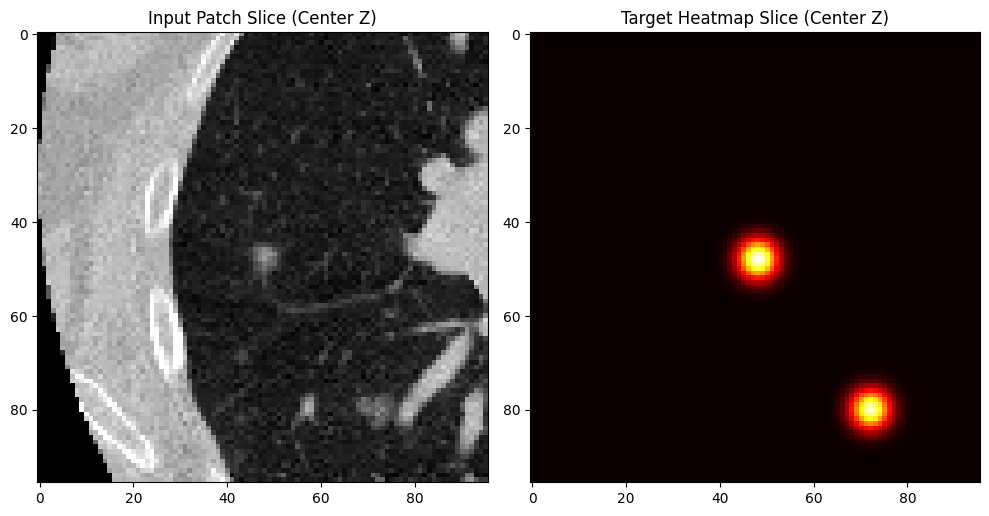

In [28]:
# --- Verify a batch ---
try:
    sample_batch = next(iter(train_loader))
    print("Sample batch keys:", sample_batch.keys())
    print("Image shape:", sample_batch['image'].shape)
    print("Target heatmap shape:", sample_batch['target_heatmap'].shape)
    print("Patch origin shape:", sample_batch['patch_origin_zyx'].shape)
    # Check if metadata is a list of dicts for the batch
    print("Metadata type:", type(sample_batch['metadata']))
    if isinstance(sample_batch['metadata'], dict): # Check if collate needs custom handling
         print("First item metadata keys:", sample_batch['metadata'].keys())
    elif isinstance(sample_batch['metadata'], list):
         print("First item metadata keys:", sample_batch['metadata'][0].keys())

    # Visualize a slice from the first item in the batch
    img_slice = sample_batch['image'][0, 0, PATCH_SIZE[0]//2, :, :].cpu().numpy()
    heatmap_slice = sample_batch['target_heatmap'][0, 0, PATCH_SIZE[0]//2, :, :].cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_slice, cmap='gray')
    axes[0].set_title('Input Patch Slice (Center Z)')
    axes[1].imshow(heatmap_slice, cmap='hot')
    axes[1].set_title('Target Heatmap Slice (Center Z)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error verifying batch: {e}")
    print("Check dataset implementation, paths, and available memory.")

In [29]:
# ## 6. Model Architecture: 3D U-Net with Multi-Scale Attention
#
# We'll implement a standard 3D U-Net and integrate a simple Convolutional Block Attention Module (CBAM) like attention mechanism.

# %%
class CBAM3D(nn.Module):
    """Convolutional Block Attention Module (CBAM) for 3D"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(channel, channel // reduction, 1),
            nn.ReLU(),
            nn.Conv3d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            # Spatial attention: Use MaxPool and AvgPool across channels
            # Keep code simple: use a single conv for spatial attention demonstration
             nn.Conv3d(channel, 1, kernel_size=7, padding=3, bias=False), # Larger kernel for context
             nn.BatchNorm3d(1), # Add BN for stability
             nn.Sigmoid()
        )
        # More robust spatial attention (like original CBAM)
        # self.spatial_attention = nn.Sequential(
        #     nn.Conv3d(2, 1, kernel_size=7, padding=3, bias=False), # Conv on concatenated pool features
        #     nn.BatchNorm3d(1),
        #     nn.Sigmoid()
        # )


    def forward(self, x):
        # Channel Attention
        ca_map = self.channel_attention(x)
        x_ca = x * ca_map

        # Spatial Attention (simplified)
        sa_map = self.spatial_attention(x_ca)
        x_sa = x_ca * sa_map

        # # Spatial Attention (more like original CBAM)
        # avg_pool = torch.mean(x_ca, dim=1, keepdim=True)
        # max_pool, _ = torch.max(x_ca, dim=1, keepdim=True)
        # pool_cat = torch.cat([avg_pool, max_pool], dim=1) # Shape: (B, 2, D, H, W)
        # sa_map = self.spatial_attention(pool_cat) # Shape: (B, 1, D, H, W)
        # x_sa = x_ca * sa_map

        return x_sa

class ConvBlock3D(nn.Module):
    """Standard 3D Convolution Block: Conv -> BatchNorm -> ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        if self.use_attention:
            self.attention = CBAM3D(out_channels)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        if self.use_attention:
            x = self.attention(x)
        return x

class EncoderBlock3D(nn.Module):
    """Encoder Block: ConvBlock -> MaxPool"""
    def __init__(self, in_channels, out_channels, use_attention=False):
        super().__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels, use_attention=use_attention)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv_block(x)
        pooled = self.pool(skip)
        return pooled, skip

class DecoderBlock3D(nn.Module):
    """Decoder Block: UpConv -> Concat -> ConvBlock"""
    def __init__(self, in_channels, skip_channels, out_channels, use_attention=False):
        super().__init__()
        # Use ConvTranspose3d for up-sampling
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        # Adjust channels for concatenated input to ConvBlock
        self.conv_block = ConvBlock3D(out_channels + skip_channels, out_channels, use_attention=use_attention)

    def forward(self, x, skip):
        x = self.upconv(x)
        # Ensure spatial dimensions match for concatenation
        # Input shape: (B, C, D, H, W)
        diff_z = skip.size(2) - x.size(2)
        diff_y = skip.size(3) - x.size(3)
        diff_x = skip.size(4) - x.size(4)

        # Pad x if needed (usually needed if original dims were odd)
        x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                      diff_y // 2, diff_y - diff_y // 2,
                      diff_z // 2, diff_z - diff_z // 2])

        x = torch.cat([x, skip], dim=1) # Concatenate along channel dimension
        x = self.conv_block(x)
        return x


class UNet3D_MSA(nn.Module):
    """3D U-Net with optional CBAM Attention Blocks"""
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256], use_attention=True):
        super().__init__()
        self.use_attention = use_attention

        # Encoder Path
        self.enc1 = EncoderBlock3D(in_channels, features[0], use_attention=use_attention)
        self.enc2 = EncoderBlock3D(features[0], features[1], use_attention=use_attention)
        self.enc3 = EncoderBlock3D(features[1], features[2], use_attention=use_attention)

        # Bottleneck
        self.bottleneck = ConvBlock3D(features[2], features[3], use_attention=use_attention)

        # Decoder Path
        self.dec3 = DecoderBlock3D(features[3], features[2], features[2], use_attention=use_attention)
        self.dec2 = DecoderBlock3D(features[2], features[1], features[1], use_attention=use_attention)
        self.dec1 = DecoderBlock3D(features[1], features[0], features[0], use_attention=use_attention)

        # Final Convolution
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

        # Optional: Sigmoid activation for heatmap prediction [0, 1]
        # Handled by BCEWithLogitsLoss typically, so not applied here by default.
        # self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Encoder
        x1_p, x1_s = self.enc1(x)
        x2_p, x2_s = self.enc2(x1_p)
        x3_p, x3_s = self.enc3(x2_p)

        # Bottleneck
        b = self.bottleneck(x3_p)

        # Decoder
        d3 = self.dec3(b, x3_s)
        d2 = self.dec2(d3, x2_s)
        d1 = self.dec1(d2, x1_s)

        # Final Output
        out = self.final_conv(d1)
        # out = self.sigmoid(out) # Apply sigmoid if loss function requires it

        return out

In [30]:
# --- Instantiate the Model ---
model = UNet3D_MSA(in_channels=1, out_channels=1, features=[32, 64, 128, 256], use_attention=True).to(DEVICE)

# --- Test Model Forward Pass (with dummy data) ---
try:
    dummy_input = torch.randn(1, 1, *PATCH_SIZE).to(DEVICE)
    output = model(dummy_input)
    print(f"Model instantiated successfully.")
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}")
except Exception as e:
    print(f"Error during model instantiation or forward pass: {e}")

Model instantiated successfully.
Input shape: torch.Size([1, 1, 96, 96, 96])
Output shape: torch.Size([1, 1, 96, 96, 96])
Total trainable parameters: 5,856,923


In [31]:
# ## 7. Loss Function and Optimizer

# %%
# --- Loss Function ---
# BCEWithLogitsLoss is suitable for heatmap regression treated as pixel-wise binary classification (presence/absence of nodule center influence)
# It includes the Sigmoid activation internally.
# Using pos_weight to handle class imbalance (many background voxels vs few nodule voxels)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POSITIVE_WEIGHT]).to(DEVICE))

# Alternative: MSELoss (treat as direct regression) - might need sigmoid on model output
# criterion = nn.MSELoss()

# Alternative: Focal Loss (implement separately if needed)

# --- Optimizer ---
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# --- Learning Rate Scheduler ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# --- Gradient Scaler (for Mixed Precision) ---
scaler = GradScaler(enabled=torch.cuda.is_available() and DEVICE.type == 'cuda')

/tmp/ipykernel_31/1080481451.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available() and DEVICE.type == 'cuda')


In [32]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for batch in progress_bar:
        images = batch['image'].to(device)
        targets = batch['target_heatmap'].to(device)

        optimizer.zero_grad()

        # Mixed Precision Context
        with autocast(enabled=scaler.is_enabled()):
            outputs = model(images)
            loss = criterion(outputs, targets)

        # Scale loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader)
    return epoch_loss

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            images = batch['image'].to(device)
            targets = batch['target_heatmap'].to(device)

            # Mixed precision for validation inference too
            with autocast(enabled=scaler.is_enabled()):
                 outputs = model(images)
                 loss = criterion(outputs, targets)

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader)
    return epoch_loss

Starting Training...


Training:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_31/1909000018.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Validation:   0%|          | 0/49 [00:00<?, ?it/s]

/tmp/ipykernel_31/1909000018.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Epoch 1/50 | Time: 391.43s | Train Loss: 0.651606 | Val Loss: 0.599638
   -> New best model saved with Val Loss: 0.599638


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/50 | Time: 366.30s | Train Loss: 0.605678 | Val Loss: 0.593992
   -> New best model saved with Val Loss: 0.593992


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/50 | Time: 365.83s | Train Loss: 0.570080 | Val Loss: 0.536548
   -> New best model saved with Val Loss: 0.536548


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4/50 | Time: 365.89s | Train Loss: 0.527542 | Val Loss: 0.549919


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5/50 | Time: 365.89s | Train Loss: 0.484620 | Val Loss: 0.407413
   -> New best model saved with Val Loss: 0.407413


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6/50 | Time: 365.91s | Train Loss: 0.446979 | Val Loss: 0.308150
   -> New best model saved with Val Loss: 0.308150


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7/50 | Time: 365.79s | Train Loss: 0.411587 | Val Loss: 0.414231


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8/50 | Time: 365.77s | Train Loss: 0.377131 | Val Loss: 0.486843


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9/50 | Time: 365.64s | Train Loss: 0.342236 | Val Loss: 0.347169


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10/50 | Time: 365.70s | Train Loss: 0.309905 | Val Loss: 0.396034


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11/50 | Time: 365.71s | Train Loss: 0.275606 | Val Loss: 0.305180
   -> New best model saved with Val Loss: 0.305180


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12/50 | Time: 365.62s | Train Loss: 0.235875 | Val Loss: 0.239661
   -> New best model saved with Val Loss: 0.239661


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13/50 | Time: 365.65s | Train Loss: 0.201649 | Val Loss: 0.202352
   -> New best model saved with Val Loss: 0.202352


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14/50 | Time: 365.56s | Train Loss: 0.171767 | Val Loss: 0.146966
   -> New best model saved with Val Loss: 0.146966


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15/50 | Time: 365.57s | Train Loss: 0.148247 | Val Loss: 0.123898
   -> New best model saved with Val Loss: 0.123898


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16/50 | Time: 365.61s | Train Loss: 0.128250 | Val Loss: 0.088639
   -> New best model saved with Val Loss: 0.088639


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17/50 | Time: 365.63s | Train Loss: 0.111953 | Val Loss: 0.102737


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18/50 | Time: 365.60s | Train Loss: 0.097494 | Val Loss: 0.086065
   -> New best model saved with Val Loss: 0.086065


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19/50 | Time: 365.64s | Train Loss: 0.084996 | Val Loss: 0.082502
   -> New best model saved with Val Loss: 0.082502


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20/50 | Time: 365.53s | Train Loss: 0.072986 | Val Loss: 0.061216
   -> New best model saved with Val Loss: 0.061216


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21/50 | Time: 365.53s | Train Loss: 0.063230 | Val Loss: 0.056949
   -> New best model saved with Val Loss: 0.056949


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22/50 | Time: 365.55s | Train Loss: 0.053865 | Val Loss: 0.045062
   -> New best model saved with Val Loss: 0.045062


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23/50 | Time: 365.55s | Train Loss: 0.043536 | Val Loss: 0.038418
   -> New best model saved with Val Loss: 0.038418


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24/50 | Time: 365.60s | Train Loss: 0.038050 | Val Loss: 0.040464


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25/50 | Time: 365.62s | Train Loss: 0.034430 | Val Loss: 0.024876
   -> New best model saved with Val Loss: 0.024876


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 26/50 | Time: 365.70s | Train Loss: 0.030363 | Val Loss: 0.053216


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 27/50 | Time: 365.61s | Train Loss: 0.027356 | Val Loss: 0.019032
   -> New best model saved with Val Loss: 0.019032


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 28/50 | Time: 365.61s | Train Loss: 0.024601 | Val Loss: 0.033463


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 29/50 | Time: 365.59s | Train Loss: 0.022310 | Val Loss: 0.021913


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 30/50 | Time: 365.52s | Train Loss: 0.020411 | Val Loss: 0.018362
   -> New best model saved with Val Loss: 0.018362


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 31/50 | Time: 365.50s | Train Loss: 0.019687 | Val Loss: 0.016241
   -> New best model saved with Val Loss: 0.016241


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 32/50 | Time: 365.62s | Train Loss: 0.018045 | Val Loss: 0.013212
   -> New best model saved with Val Loss: 0.013212


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 33/50 | Time: 365.54s | Train Loss: 0.016626 | Val Loss: 0.013121
   -> New best model saved with Val Loss: 0.013121


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 34/50 | Time: 365.53s | Train Loss: 0.015486 | Val Loss: 0.010925
   -> New best model saved with Val Loss: 0.010925


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 35/50 | Time: 365.65s | Train Loss: 0.014736 | Val Loss: 0.009705
   -> New best model saved with Val Loss: 0.009705


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 36/50 | Time: 365.71s | Train Loss: 0.014697 | Val Loss: 0.009114
   -> New best model saved with Val Loss: 0.009114


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 37/50 | Time: 365.58s | Train Loss: 0.013520 | Val Loss: 0.008411
   -> New best model saved with Val Loss: 0.008411


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 38/50 | Time: 365.85s | Train Loss: 0.012841 | Val Loss: 0.007850
   -> New best model saved with Val Loss: 0.007850


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 39/50 | Time: 365.51s | Train Loss: 0.012934 | Val Loss: 0.008475


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 40/50 | Time: 365.49s | Train Loss: 0.012027 | Val Loss: 0.010295


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 41/50 | Time: 365.55s | Train Loss: 0.011581 | Val Loss: 0.006210
   -> New best model saved with Val Loss: 0.006210


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 42/50 | Time: 365.55s | Train Loss: 0.011289 | Val Loss: 0.006437


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 43/50 | Time: 365.70s | Train Loss: 0.011080 | Val Loss: 0.006086
   -> New best model saved with Val Loss: 0.006086


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 44/50 | Time: 365.48s | Train Loss: 0.010674 | Val Loss: 0.006243


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 45/50 | Time: 365.47s | Train Loss: 0.010376 | Val Loss: 0.005748
   -> New best model saved with Val Loss: 0.005748


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 46/50 | Time: 365.50s | Train Loss: 0.010749 | Val Loss: 0.005744
   -> New best model saved with Val Loss: 0.005744


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 47/50 | Time: 365.43s | Train Loss: 0.010277 | Val Loss: 0.005359
   -> New best model saved with Val Loss: 0.005359


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 48/50 | Time: 365.41s | Train Loss: 0.009934 | Val Loss: 0.005428


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 49/50 | Time: 365.34s | Train Loss: 0.009658 | Val Loss: 0.004961
   -> New best model saved with Val Loss: 0.004961


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validation:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 50/50 | Time: 365.44s | Train Loss: 0.009678 | Val Loss: 0.004262
   -> New best model saved with Val Loss: 0.004262

Training Finished. Total time: 305.16 minutes
Best Validation Loss: 0.004262
Model saved to: /kaggle/working/results_msa_unet/best_model_msa_unet.pth


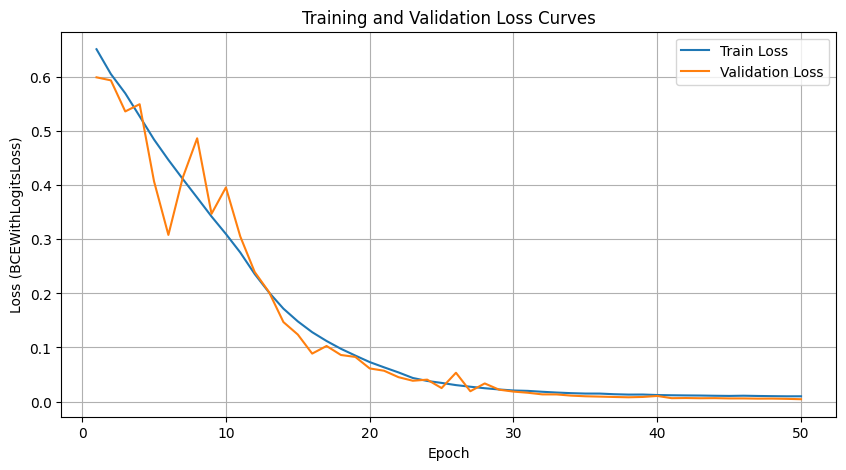

In [33]:
# --- Main Training Execution ---
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting Training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # Training
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate_one_epoch(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)

    epoch_duration = time.time() - epoch_start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Time: {epoch_duration:.2f}s | "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Update LR Scheduler
    scheduler.step(val_loss)

    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"   -> New best model saved with Val Loss: {best_val_loss:.6f}")

total_training_time = time.time() - start_time
print(f"\nTraining Finished. Total time: {total_training_time/60:.2f} minutes")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"Model saved to: {MODEL_SAVE_PATH}")

# --- Plot Training Curves ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCEWithLogitsLoss)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig(RESULTS_DIR / "loss_curves.png")
plt.show()


In [34]:
def find_heatmap_peaks(heatmap, threshold=NMS_THRESHOLD, footprint_size=NMS_FOOTPRINT_SIZE):
    """Finds local maxima in a heatmap above a threshold."""
    # Apply maximum filter to find local peaks
    footprint = generate_binary_structure(heatmap.ndim, footprint_size) # Adjust connectivity as needed
    local_max = maximum_filter(heatmap, footprint=footprint) == heatmap

    # Apply threshold mask
    threshold_mask = heatmap > threshold

    # Combine masks
    peaks_mask = local_max & threshold_mask

    # Get coordinates of the peaks
    peak_coords = np.argwhere(peaks_mask) # Returns array of [z, y, x] indices
    peak_values = heatmap[peaks_mask]

    # Sort peaks by value (confidence) in descending order
    if len(peak_coords) > 0:
        sorted_indices = np.argsort(peak_values)[::-1]
        peak_coords = peak_coords[sorted_indices]
        peak_values = peak_values[sorted_indices]

    return peak_coords, peak_values # List of (z, y, x), List of confidences

def convert_patch_peak_to_world(peak_voxel_zyx, patch_origin_zyx, metadata):
    """Converts a peak's voxel coordinates relative to a patch back to world coordinates."""
    # 1. Absolute voxel coordinate in the resampled full volume
    absolute_voxel_zyx = patch_origin_zyx + peak_voxel_zyx

    # 2. Convert absolute voxel (z, y, x) to world coordinate (x, y, z)
    resampled_origin_xyz = metadata['resampled_origin']
    resampled_spacing_xyz = metadata['resampled_spacing']

    # Need absolute voxel in (x, y, z) order for voxel_to_world function
    # absolute_voxel_xyz = absolute_voxel_zyx[::-1] # Reverse z,y,x -> x,y,z
    # world_coord_xyz = voxel_to_world(absolute_voxel_xyz, resampled_origin_xyz, resampled_spacing_xyz)

    # Or calculate directly using numpy order (z, y, x) and spacing (x, y, z)
    # world_coord = origin + voxel * spacing
    # Note: SimpleITK origin/spacing is (x, y, z)
    world_coord_x = resampled_origin_xyz[0] + absolute_voxel_zyx[2] * resampled_spacing_xyz[0]
    world_coord_y = resampled_origin_xyz[1] + absolute_voxel_zyx[1] * resampled_spacing_xyz[1]
    world_coord_z = resampled_origin_xyz[2] + absolute_voxel_zyx[0] * resampled_spacing_xyz[2]
    world_coord_xyz = np.array([world_coord_x, world_coord_y, world_coord_z])

    return world_coord_xyz


# %% [markdown]
# ## 10. Inference Pipeline Example

# %%
def predict_scan_nodules(series_uid, model, metadata_dict, preprocessed_dir, device,
                         patch_size=PATCH_SIZE, stride=STRIDE, batch_size=BATCH_SIZE,
                         nms_threshold=NMS_THRESHOLD, nms_footprint=NMS_FOOTPRINT_SIZE):
    """Performs inference on a full scan using overlapping patches."""
    if series_uid not in metadata_dict:
        print(f"Error: Metadata not found for {series_uid}")
        return []

    meta = metadata_dict[series_uid]
    model.eval()

    # Load preprocessed volume
    volume_path = preprocessed_dir / f"{series_uid}_image.npy"
    if not volume_path.exists():
        print(f"Error: Preprocessed volume not found for {series_uid}")
        return []
    volume = np.load(volume_path)
    volume_tensor = torch.from_numpy(volume).float().unsqueeze(0).unsqueeze(0) # Add batch and channel dim

    # Get volume shape (z, y, x)
    scan_shape_zyx = np.array(volume.shape)
    patch_size_zyx = np.array(patch_size)
    stride_zyx = np.array(stride)

    # Prepare full-volume heatmap and count map (for averaging overlaps)
    full_heatmap = torch.zeros_like(volume_tensor, device='cpu', dtype=torch.float32) # Use CPU initially for potentially large volumes
    count_map = torch.zeros_like(volume_tensor, device='cpu', dtype=torch.float32)

    patch_origins = []
    # Generate patch start coordinates using strides
    for z in range(0, scan_shape_zyx[0] - patch_size_zyx[0] + 1, stride_zyx[0]):
        for y in range(0, scan_shape_zyx[1] - patch_size_zyx[1] + 1, stride_zyx[1]):
            for x in range(0, scan_shape_zyx[2] - patch_size_zyx[2] + 1, stride_zyx[2]):
                patch_origins.append(np.array([z, y, x]))

    # Handle edges: Add patches starting at the end minus patch size if needed
    end_coords = scan_shape_zyx - patch_size_zyx
    for z_flag in [False, True]:
         for y_flag in [False, True]:
             for x_flag in [False, True]:
                if not (z_flag or y_flag or x_flag): continue # Skip origin (0,0,0) handled above
                z = end_coords[0] if z_flag else 0
                y = end_coords[1] if y_flag else 0
                x = end_coords[2] if x_flag else 0
                # Only add if positive (scan larger than patch)
                if z >= 0 and y >= 0 and x >= 0:
                     origin = np.array([z, y, x])
                     # Avoid adding duplicate origins if stride covers edges perfectly
                     is_new = True
                     for existing in patch_origins:
                         if np.array_equal(origin, existing):
                             is_new = False
                             break
                     if is_new:
                         patch_origins.append(origin)


    print(f"Processing {series_uid} with {len(patch_origins)} patches...")

    # Process patches in batches
    patch_batch = []
    origin_batch = []
    with torch.no_grad():
        for origin_zyx in tqdm(patch_origins, desc=f"Inferring {series_uid}", leave=False):
            z, y, x = origin_zyx
            patch = volume_tensor[:, :, z:z+patch_size_zyx[0], y:y+patch_size_zyx[1], x:x+patch_size_zyx[2]]
            patch_batch.append(patch)
            origin_batch.append(origin_zyx)

            if len(patch_batch) == batch_size or origin_zyx is patch_origins[-1]:
                batch_tensor = torch.cat(patch_batch, dim=0).to(device)

                with autocast(enabled=scaler.is_enabled()):
                    outputs = model(batch_tensor)
                    # Apply sigmoid because BCEWithLogitsLoss was used (output are logits)
                    outputs = torch.sigmoid(outputs)

                outputs_cpu = outputs.cpu()

                # Add patch predictions to the full heatmap
                for i, patch_output in enumerate(outputs_cpu):
                    oz, oy, ox = origin_batch[i]
                    full_heatmap[:, :, oz:oz+patch_size_zyx[0], oy:oy+patch_size_zyx[1], ox:ox+patch_size_zyx[2]] += patch_output
                    count_map[:, :, oz:oz+patch_size_zyx[0], oy:oy+patch_size_zyx[1], ox:ox+patch_size_zyx[2]] += 1

                patch_batch = []
                origin_batch = []

    # Avoid division by zero
    count_map[count_map == 0] = 1
    # Average overlapping predictions
    averaged_heatmap = (full_heatmap / count_map).squeeze().numpy() # Shape: (D, H, W)

    # Find peaks in the averaged heatmap
    peak_voxels_zyx, peak_values = find_heatmap_peaks(averaged_heatmap, threshold=nms_threshold, footprint_size=nms_footprint)

    # Convert peak voxel coordinates to world coordinates
    detected_nodules = []
    for voxel_zyx, confidence in zip(peak_voxels_zyx, peak_values):
        world_coord_xyz = convert_patch_peak_to_world(voxel_zyx, np.array([0,0,0]), meta) # Origin is 0 for full volume

        # Estimate radius - very crude: use heatmap sigma or fixed value
        # A better approach would involve analysing the heatmap region or training a radius regressor.
        estimated_radius_mm = HEATMAP_SIGMA * np.mean(meta['resampled_spacing']) # Rough estimate based on sigma
        # Link to actual annotations for radius if needed during evaluation

        detected_nodules.append({
            'seriesuid': series_uid,
            'coordX': world_coord_xyz[0],
            'coordY': world_coord_xyz[1],
            'coordZ': world_coord_xyz[2],
            'voxelX': voxel_zyx[2], # Store voxel coords too for debugging/vis
            'voxelY': voxel_zyx[1],
            'voxelZ': voxel_zyx[0],
            'probability': confidence,
            'estimated_radius_mm': estimated_radius_mm
        })

    print(f"Found {len(detected_nodules)} candidate nodules in {series_uid}.")
    return detected_nodules, averaged_heatmap # Return heatmap for visualization


/tmp/ipykernel_31/3590780822.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))


Loaded best model weights from /kaggle/working/results_msa_unet/best_model_msa_unet.pth

Running inference on example scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874:   0%|          | 0/252 [00:00<?, ?…

/tmp/ipykernel_31/1174025699.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 115 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.
Inference took 94.21 seconds.
Example detections:
  Coords (X,Y,Z): (153.00, 307.00, -560.10), Prob: 0.2285
  Coords (X,Y,Z): (155.00, 306.00, -560.10), Prob: 0.2285
  Coords (X,Y,Z): (151.00, 309.00, -560.10), Prob: 0.2284
  Coords (X,Y,Z): (157.00, 309.00, -560.10), Prob: 0.2283
  Coords (X,Y,Z): (157.00, 306.00, -560.10), Prob: 0.2282


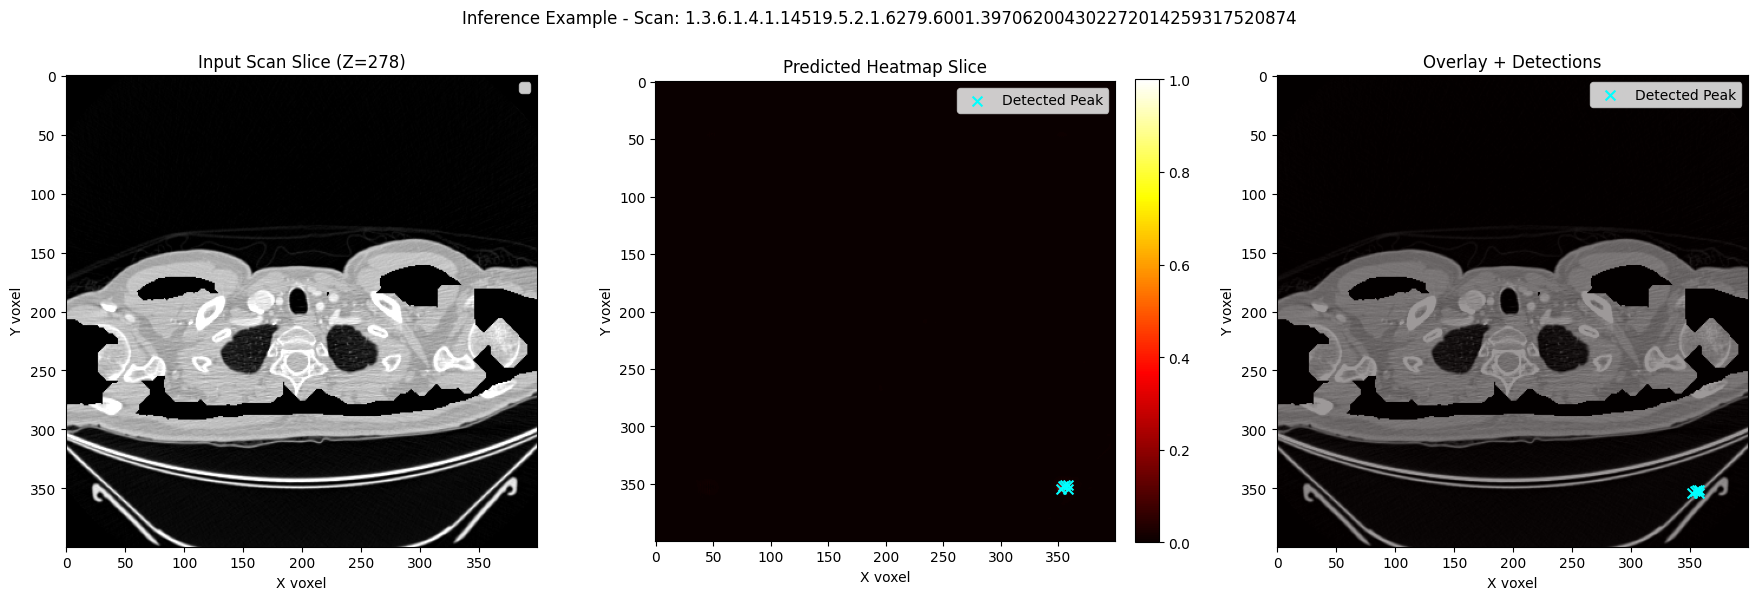

In [35]:
# --- Example Inference on one validation scan ---
if val_uids:
    # Load the best model weights
    if MODEL_SAVE_PATH.exists():
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        print(f"Loaded best model weights from {MODEL_SAVE_PATH}")

        example_uid = random.choice(val_uids)
        print(f"\nRunning inference on example scan: {example_uid}")

        start_inf_time = time.time()
        candidate_nodules, predicted_heatmap = predict_scan_nodules(example_uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE)
        inference_time = time.time() - start_inf_time

        print(f"Inference took {inference_time:.2f} seconds.")
        print("Example detections:")
        for nod in candidate_nodules[:5]: # Print first 5
            print(f"  Coords (X,Y,Z): ({nod['coordX']:.2f}, {nod['coordY']:.2f}, {nod['coordZ']:.2f}), Prob: {nod['probability']:.4f}")

        # --- Visualize Inference Result ---
        if example_uid in metadata_dict:
            # Load original preprocessed image for visualization context
            volume_path = PREPROCESSED_DIR / f"{example_uid}_image.npy"
            volume_np = np.load(volume_path)

            # Get ground truth nodules for this scan
            gt_nodules = annotations_df[annotations_df['seriesuid'] == example_uid]
            gt_centers_voxel = []
            meta = metadata_dict[example_uid]
            for _, row in gt_nodules.iterrows():
                wc = np.array([row['coordX'], row['coordY'], row['coordZ']])
                vc_xyz = world_to_voxel(wc, meta['resampled_origin'], meta['resampled_spacing'])
                vc_zyx = np.round(vc_xyz[::-1]).astype(int)
                if np.all(vc_zyx >= 0) and np.all(vc_zyx < volume_np.shape):
                     gt_centers_voxel.append(vc_zyx) # z, y, x

            # Find a slice with a GT nodule or a high-confidence prediction
            display_slice_z = volume_np.shape[0] // 2 # Default center slice
            if gt_centers_voxel:
                display_slice_z = gt_centers_voxel[0][0] # Use Z-coord of first GT nodule
            elif candidate_nodules:
                 display_slice_z = candidate_nodules[0]['voxelZ'] # Use Z-coord of highest-prob prediction

            display_slice_z = np.clip(display_slice_z, 0, volume_np.shape[0]-1) # Ensure valid index

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Image Slice
            axes[0].imshow(volume_np[display_slice_z, :, :], cmap='gray')
            axes[0].set_title(f'Input Scan Slice (Z={display_slice_z})')
            axes[0].set_xlabel('X voxel')
            axes[0].set_ylabel('Y voxel')

            # Heatmap Slice
            im = axes[1].imshow(predicted_heatmap[display_slice_z, :, :], cmap='hot', vmin=0, vmax=1)
            axes[1].set_title('Predicted Heatmap Slice')
            axes[1].set_xlabel('X voxel')
            axes[1].set_ylabel('Y voxel')
            fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)


            # Overlay Slice
            axes[2].imshow(volume_np[display_slice_z, :, :], cmap='gray')
            axes[2].imshow(predicted_heatmap[display_slice_z, :, :], cmap='hot', alpha=0.4, vmin=0.1, vmax=1.0) # Overlay heatmap
            axes[2].set_title('Overlay + Detections')
            axes[2].set_xlabel('X voxel')
            axes[2].set_ylabel('Y voxel')

            # Plot GT nodules on this slice
            for z, y, x in gt_centers_voxel:
                 if z == display_slice_z:
                     axes[0].scatter(x, y, color='lime', marker='o', s=80, facecolors='none', label='GT Nodule' if 'GT Nodule' not in [c.get_label() for c in axes[0].collections] else "")
                     axes[2].scatter(x, y, color='lime', marker='o', s=80, facecolors='none', label='GT Nodule' if 'GT Nodule' not in [c.get_label() for c in axes[2].collections] else "")


            # Plot detected nodules on this slice
            for nod in candidate_nodules:
                if nod['voxelZ'] == display_slice_z:
                     axes[1].scatter(nod['voxelX'], nod['voxelY'], color='cyan', marker='x', s=50, label='Detected Peak' if 'Detected Peak' not in [c.get_label() for c in axes[1].collections] else "")
                     axes[2].scatter(nod['voxelX'], nod['voxelY'], color='cyan', marker='x', s=50, label='Detected Peak' if 'Detected Peak' not in [c.get_label() for c in axes[2].collections] else "")


            axes[0].legend()
            axes[1].legend()
            axes[2].legend()
            plt.suptitle(f"Inference Example - Scan: {example_uid}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.savefig(RESULTS_DIR / f"inference_example_{example_uid}.png")
            plt.show()

    else:
        print("Model file not found. Cannot run inference example.")
else:
    print("Validation set is empty. Cannot run inference example.")

In [36]:
# ## 11. Evaluation (FROC, Sensitivity, Confusion Matrix)
#
# This requires running inference on the entire validation set and comparing predictions against ground truth annotations. FROC evaluation is standard for LUNA16.
#
# **Note:** A full FROC evaluation is complex and involves matching predictions to GT nodules based on distance and handling multiple detections per nodule. We'll implement a simplified version focusing on sensitivity and basic metrics at a fixed detection threshold. For rigorous results, consider using established FROC calculation scripts (like those provided by LUNA or adapted versions).

# %%
def evaluate_predictions(all_predictions_df, ground_truth_df, metadata_dict, distance_threshold_mm=5.0):
    """
    Evaluates predictions against ground truth.

    Args:
        all_predictions_df (pd.DataFrame): DataFrame with columns ['seriesuid', 'coordX', 'coordY', 'coordZ', 'probability']
        ground_truth_df (pd.DataFrame): DataFrame with columns ['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm']
        metadata_dict (dict): Dictionary mapping seriesuid to metadata (needed if coordinate conversion is involved, but here assumes coords are already world).
        distance_threshold_mm (float): Maximum distance (in mm) for a prediction to be matched to a GT nodule.

    Returns:
        dict: Dictionary containing evaluation metrics (sensitivity, average FP per scan, etc.)
        pd.DataFrame: DataFrame with match status added to predictions.
    """
    predictions = all_predictions_df.copy()
    ground_truth = ground_truth_df.copy()

    predictions['matched_gt_index'] = -1
    predictions['distance_to_gt'] = np.inf
    predictions['is_tp'] = False
    ground_truth['is_detected'] = False
    ground_truth['detected_by_pred_index'] = -1

    # Group by seriesuid for matching
    all_series_uids = ground_truth['seriesuid'].unique()
    true_positives = 0
    false_positives = 0
    false_negatives = 0 # Total GT nodules - True Positives

    total_gt_nodules = len(ground_truth)
    num_scans = len(all_series_uids)

    matched_pairs = [] # Store (pred_idx, gt_idx, dist)

    print(f"Starting evaluation on {num_scans} scans with {total_gt_nodules} GT nodules and {len(predictions)} predictions.")

    for seriesuid in tqdm(all_series_uids, desc="Matching GT and Predictions"):
        gt_scan = ground_truth[ground_truth['seriesuid'] == seriesuid].reset_index()
        preds_scan = predictions[predictions['seriesuid'] == seriesuid].sort_values('probability', ascending=False).reset_index()

        if preds_scan.empty:
            continue # No predictions for this scan

        gt_coords = gt_scan[['coordX', 'coordY', 'coordZ']].values
        pred_coords = preds_scan[['coordX', 'coordY', 'coordZ']].values

        # Calculate pairwise distances (euclidean)
        # Using scipy's cdist is efficient
        from scipy.spatial.distance import cdist
        distances = cdist(pred_coords, gt_coords) # Shape: (num_preds, num_gt)

        # Greedy matching: Iterate through predictions (highest prob first)
        gt_matched_flags = np.zeros(len(gt_scan), dtype=bool)

        for pred_idx in range(len(preds_scan)):
            pred_row_idx = preds_scan.loc[pred_idx, 'index'] # Original index in 'predictions' df

            # Find closest GT nodule(s) within threshold for this prediction
            dists_to_pred = distances[pred_idx, :]
            possible_matches = np.where((dists_to_pred <= distance_threshold_mm) & (~gt_matched_flags))[0]

            if len(possible_matches) > 0:
                # Found one or more potential GT matches not yet matched
                # Choose the closest one
                best_match_gt_local_idx = possible_matches[np.argmin(dists_to_pred[possible_matches])]
                best_match_dist = dists_to_pred[best_match_gt_local_idx]

                # Mark this GT as matched
                gt_matched_flags[best_match_gt_local_idx] = True

                # Update prediction dataframe
                gt_row_idx = gt_scan.loc[best_match_gt_local_idx, 'index'] # Original index in 'ground_truth' df
                predictions.loc[pred_row_idx, 'matched_gt_index'] = gt_row_idx
                predictions.loc[pred_row_idx, 'distance_to_gt'] = best_match_dist
                predictions.loc[pred_row_idx, 'is_tp'] = True # This prediction is a True Positive

                # Update ground truth dataframe
                ground_truth.loc[gt_row_idx, 'is_detected'] = True
                ground_truth.loc[gt_row_idx, 'detected_by_pred_index'] = pred_row_idx

                matched_pairs.append((pred_row_idx, gt_row_idx, best_match_dist))
            else:
                # No available GT nodule within threshold, this prediction is a False Positive
                # (is_tp remains False, which indicates FP)
                pass # Already initialized as FP

    # Calculate overall metrics
    true_positives = predictions['is_tp'].sum()
    false_positives = len(predictions) - true_positives
    false_negatives = total_gt_nodules - ground_truth['is_detected'].sum() # GT nodules not detected by any prediction

    sensitivity = true_positives / total_gt_nodules if total_gt_nodules > 0 else 0
    avg_fp_per_scan = false_positives / num_scans if num_scans > 0 else 0

    metrics = {
        'total_gt_nodules': total_gt_nodules,
        'total_predictions': len(predictions),
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'sensitivity': sensitivity,
        'average_fp_per_scan': avg_fp_per_scan,
        'distance_threshold_mm': distance_threshold_mm,
        'num_scans_evaluated': num_scans
    }

    print("\nEvaluation Summary:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

    return metrics, predictions, ground_truth


def plot_froc_curve(predictions_df, ground_truth_df, num_scans, distance_threshold_mm=5.0):
    """Calculates and plots the FROC curve."""
    # Similar matching logic as evaluate_predictions, but done across thresholds
    all_predictions = []
    print("Calculating FROC points...")

    # Run inference on all validation scans
    if MODEL_SAVE_PATH.exists():
         model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
         print(f"Loaded best model weights from {MODEL_SAVE_PATH}")
    else:
         print("Model file not found. Cannot perform full evaluation.")
         return

    for uid in tqdm(val_uids, desc="Running inference for FROC"):
         preds, _ = predict_scan_nodules(uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE, batch_size=BATCH_SIZE*2) # Use larger batch for inference
         all_predictions.extend(preds)

    if not all_predictions:
         print("No predictions generated. Cannot compute FROC.")
         return

    predictions_df = pd.DataFrame(all_predictions)
    ground_truth = ground_truth_df[ground_truth_df['seriesuid'].isin(val_uids)].copy() # Only GT for validation scans
    total_gt_nodules = len(ground_truth)
    num_scans = len(val_uids)

    if total_gt_nodules == 0:
        print("No ground truth nodules found in validation set.")
        return

    # Sort predictions by probability
    predictions_df = predictions_df.sort_values('probability', ascending=False).reset_index(drop=True)

    sensitivities = []
    avg_fps = []
    thresholds = np.unique(predictions_df['probability']) # Use unique probabilities as thresholds
    thresholds = np.append(thresholds, 0) # Add 0 threshold
    thresholds = np.sort(thresholds)[::-1] # High to low prob

    gt_coords_map = {}
    for uid in val_uids:
        gt_scan = ground_truth[ground_truth['seriesuid'] == uid]
        if not gt_scan.empty:
             gt_coords_map[uid] = gt_scan[['coordX', 'coordY', 'coordZ']].values
        else:
             gt_coords_map[uid] = np.empty((0,3))


    # Pre-calculate GT indices for faster lookup
    gt_indices_map = {uid: ground_truth[ground_truth['seriesuid'] == uid].index for uid in val_uids}


    for thresh in tqdm(thresholds, desc="Calculating FROC points", leave=False):
        preds_above_thresh = predictions_df[predictions_df['probability'] >= thresh]
        num_preds_at_thresh = len(preds_above_thresh)

        tp = 0
        fp = 0
        gt_detected_at_thresh = {idx: False for idx_list in gt_indices_map.values() for idx in idx_list} # Reset detection status for each threshold


        # Iterate through predictions above threshold for matching
        for _, pred_row in preds_above_thresh.iterrows():
            seriesuid = pred_row['seriesuid']
            pred_coord = pred_row[['coordX', 'coordY', 'coordZ']].values

            if seriesuid not in gt_coords_map or gt_coords_map[seriesuid].shape[0] == 0:
                fp += 1 # FP if no GT nodules exist for this scan
                continue

            gt_coords_scan = gt_coords_map[seriesuid]
            gt_indices_scan = gt_indices_map[seriesuid]

            distances = np.linalg.norm(gt_coords_scan - pred_coord, axis=1)
            possible_matches = np.where(distances <= distance_threshold_mm)[0]

            best_match_gt_local_idx = -1
            min_dist = np.inf

            # Find the closest *available* GT match
            for local_idx in possible_matches:
                global_gt_idx = gt_indices_scan[local_idx]
                if not gt_detected_at_thresh[global_gt_idx]: # If this GT nodule hasn't been detected yet at this threshold
                     if distances[local_idx] < min_dist:
                         min_dist = distances[local_idx]
                         best_match_gt_local_idx = local_idx


            if best_match_gt_local_idx != -1:
                 # Found a match, mark GT as detected for this threshold
                 global_gt_idx = gt_indices_scan[best_match_gt_local_idx]
                 gt_detected_at_thresh[global_gt_idx] = True
                 tp += 1
            else:
                 # No available match found within distance, it's an FP
                 fp += 1

        sensitivity = tp / total_gt_nodules if total_gt_nodules > 0 else 0
        avg_fp = fp / num_scans if num_scans > 0 else 0

        sensitivities.append(sensitivity)
        avg_fps.append(avg_fp)


    # Plot FROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(avg_fps, sensitivities, marker='o', linestyle='-')
    plt.xlabel('Average False Positives per Scan')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title(f'Free-response Receiver Operating Characteristic (FROC) Curve\n(Distance Threshold: {distance_threshold_mm}mm)')
    # Standard LUNA evaluation points
    froc_points_target = [0.125, 0.25, 0.5, 1, 2, 4, 8]
    plt.xticks(froc_points_target + [0])
    plt.xlim(left=0)
    plt.ylim(0, 1.05)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Annotate sensitivity at standard FP rates
    sens_at_fp = []
    for fp_target in froc_points_target:
         sens = np.interp(fp_target, avg_fps, sensitivities) # Linear interpolation
         sens_at_fp.append(sens)
         plt.scatter(fp_target, sens, color='red', zorder=5)
         plt.text(fp_target + 0.1, sens, f'{sens:.3f}', color='red', va='bottom')

    print("\nSensitivity @ FP rates:")
    for fp_val, sens_val in zip(froc_points_target, sens_at_fp):
        print(f"  @ {fp_val:.3f} FP/scan: {sens_val:.4f}")

    # Calculate Competition Performance Metric (CPM) - average sensitivity at the standard points
    cpm = np.mean(sens_at_fp)
    print(f"\nCompetition Performance Metric (CPM): {cpm:.4f}")
    plt.text(0.5, 0.1, f"CPM = {cpm:.4f}", transform=plt.gca().transAxes, ha='center')

    plt.savefig(RESULTS_DIR / "froc_curve.png")
    plt.show()

    return {'sensitivities': sensitivities, 'avg_fps': avg_fps, 'thresholds': thresholds, 'cpm': cpm}


# --- Run Evaluation ---
# First, generate predictions for all validation scans
all_predictions_list = []
if MODEL_SAVE_PATH.exists():
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print(f"\nLoaded best model weights from {MODEL_SAVE_PATH} for evaluation.")
    print("Generating predictions for all validation scans...")
    for uid in tqdm(val_uids, desc="Final Evaluation Inference"):
        preds, _ = predict_scan_nodules(uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE, batch_size=BATCH_SIZE*2)
        all_predictions_list.extend(preds)

    if all_predictions_list:
        all_predictions_df = pd.DataFrame(all_predictions_list)

        # --- Evaluate at a fixed threshold (e.g., NMS threshold used in inference) ---
        print(f"\n--- Evaluating at fixed threshold: {NMS_THRESHOLD} ---")
        # We need GT for validation set only
        val_gt_df = annotations_df[annotations_df['seriesuid'].isin(val_uids)].copy()

        # Filter predictions by the chosen threshold before evaluation
        predictions_at_threshold_df = all_predictions_df[all_predictions_df['probability'] >= NMS_THRESHOLD].copy()

        eval_metrics, preds_eval_df, gt_eval_df = evaluate_predictions(
            predictions_at_threshold_df,
            val_gt_df,
            metadata_dict,
            distance_threshold_mm=5.0 # Common threshold, adjust if needed
        )

        # --- Confusion Matrix at this threshold ---
        # Based on the matched results
        # TP = eval_metrics['true_positives']
        # FP = eval_metrics['false_positives']
        # FN = eval_metrics['false_negatives']
        # TN = ? Hard to define True Negatives at candidate level. Often omitted.
        # We can visualize based on TP, FP, FN counts
        print("\nConfusion Matrix (Candidate Level):")
        print(f"  True Positives (Detected Nodules): {eval_metrics['true_positives']}")
        print(f"  False Positives (Incorrect Detections): {eval_metrics['false_positives']}")
        print(f"  False Negatives (Missed Nodules): {eval_metrics['false_negatives']}")

        # --- Plot FROC Curve ---
        print("\n--- Generating FROC Curve ---")
        froc_results = plot_froc_curve(all_predictions_df, annotations_df, len(val_uids), distance_threshold_mm=5.0)

    else:
        print("No predictions were generated for the validation set.")

else:
    print("Best model not found. Cannot run evaluation.")


Loaded best model weights from /kaggle/working/results_msa_unet/best_model_msa_unet.pth for evaluation.
Generating predictions for all validation scans...


/tmp/ipykernel_31/637865644.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))


Final Evaluation Inference:   0%|          | 0/9 [00:00<?, ?it/s]

Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831:   0%|          | 0/252 [00:00<?, ?…

/tmp/ipykernel_31/1174025699.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 133 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718 with 391 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718:   0%|          | 0/391 [00:00<?, ?…

Found 106 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/157 [00:00<?, ?…

Found 171 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097 with 151 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097:   0%|          | 0/151 [00:00<?, ?…

Found 178 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495:   0%|          | 0/187 [00:00<?, ?…

Found 95 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260:   0%|          | 0/252 [00:00<?, ?…

Found 90 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874:   0%|          | 0/252 [00:00<?, ?…

Found 115 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820 with 223 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820:   0%|          | 0/223 [00:00<?, ?…

Found 24 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843:   0%|          | 0/157 [00:00<?, ?…

Found 118 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.

--- Evaluating at fixed threshold: 0.1 ---
Starting evaluation on 5 scans with 8 GT nodules and 1030 predictions.


Matching GT and Predictions:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluation Summary:
  total_gt_nodules: 8
  total_predictions: 1030
  true_positives: 1
  false_positives: 1029
  false_negatives: 7
  sensitivity: 0.1250
  average_fp_per_scan: 205.8000
  distance_threshold_mm: 5.0000
  num_scans_evaluated: 5

Confusion Matrix (Candidate Level):
  True Positives (Detected Nodules): 1
  False Positives (Incorrect Detections): 1029
  False Negatives (Missed Nodules): 7

--- Generating FROC Curve ---
Calculating FROC points...
Loaded best model weights from /kaggle/working/results_msa_unet/best_model_msa_unet.pth


/tmp/ipykernel_31/637865644.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))


Running inference for FROC:   0%|          | 0/9 [00:00<?, ?it/s]

Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831:   0%|          | 0/252 [00:00<?, ?…

/tmp/ipykernel_31/1174025699.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 133 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718 with 391 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718:   0%|          | 0/391 [00:00<?, ?…

Found 106 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/157 [00:00<?, ?…

Found 171 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097 with 151 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097:   0%|          | 0/151 [00:00<?, ?…

Found 178 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495:   0%|          | 0/187 [00:00<?, ?…

Found 95 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260:   0%|          | 0/252 [00:00<?, ?…

Found 90 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874:   0%|          | 0/252 [00:00<?, ?…

Found 115 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820 with 223 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820:   0%|          | 0/223 [00:00<?, ?…

Found 24 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843:   0%|          | 0/157 [00:00<?, ?…

Found 118 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.


Calculating FROC points:   0%|          | 0/1010 [00:00<?, ?it/s]

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

In [ ]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

In [37]:
if MODEL_SAVE_PATH.exists():
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print(f"\n✅ Loaded best model weights from {MODEL_SAVE_PATH} for evaluation.")
    print("🚀 Generating predictions for all validation scans...")

    all_predictions_list = []

    for uid in tqdm(val_uids, desc="Final Evaluation Inference"):
        preds, _ = predict_scan_nodules(uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE, batch_size=BATCH_SIZE*2)
        all_predictions_list.extend(preds)

    if all_predictions_list:
        all_predictions_df = pd.DataFrame(all_predictions_list)

        # --- Evaluate at a fixed threshold (e.g., NMS threshold used in inference) ---
        print(f"\n📏 Evaluating at fixed threshold: {NMS_THRESHOLD}")
        val_gt_df = annotations_df[annotations_df['seriesuid'].isin(val_uids)].copy()

        # Filter predictions by probability threshold
        predictions_at_threshold_df = all_predictions_df[all_predictions_df['probability'] >= NMS_THRESHOLD].copy()

        eval_metrics, preds_eval_df, gt_eval_df = evaluate_predictions(
            predictions_at_threshold_df,
            val_gt_df,
            metadata_dict,
            distance_threshold_mm=5.0  # Adjustable threshold (5mm is standard)
        )

        # --- Display basic candidate-level metrics ---
        print("\n📊 Confusion Matrix (Candidate Level Approximation):")
        print(f"  ✅ True Positives (Detected Nodules): {eval_metrics['true_positives']}")
        print(f"  ❌ False Positives (Incorrect Detections): {eval_metrics['false_positives']}")
        print(f"  ❗ False Negatives (Missed Nodules): {eval_metrics['false_negatives']}")

    else:
        print("⚠️ No predictions were generated for the validation set.")

else:
    print("❌ Best model not found. Cannot run evaluation.")



✅ Loaded best model weights from /kaggle/working/results_msa_unet/best_model_msa_unet.pth for evaluation.
🚀 Generating predictions for all validation scans...


/tmp/ipykernel_31/1814487953.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))


Final Evaluation Inference:   0%|          | 0/9 [00:00<?, ?it/s]

Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831:   0%|          | 0/252 [00:00<?, ?…

/tmp/ipykernel_31/1174025699.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 133 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718 with 391 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718:   0%|          | 0/391 [00:00<?, ?…

Found 106 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/157 [00:00<?, ?…

Found 171 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097 with 151 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097:   0%|          | 0/151 [00:00<?, ?…

Found 178 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495:   0%|          | 0/187 [00:00<?, ?…

Found 95 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260:   0%|          | 0/252 [00:00<?, ?…

Found 90 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874 with 252 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874:   0%|          | 0/252 [00:00<?, ?…

Found 115 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820 with 223 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820:   0%|          | 0/223 [00:00<?, ?…

Found 24 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843:   0%|          | 0/157 [00:00<?, ?…

Found 118 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.

📏 Evaluating at fixed threshold: 0.1
Starting evaluation on 5 scans with 8 GT nodules and 1030 predictions.


Matching GT and Predictions:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluation Summary:
  total_gt_nodules: 8
  total_predictions: 1030
  true_positives: 1
  false_positives: 1029
  false_negatives: 7
  sensitivity: 0.1250
  average_fp_per_scan: 205.8000
  distance_threshold_mm: 5.0000
  num_scans_evaluated: 5

📊 Confusion Matrix (Candidate Level Approximation):
  ✅ True Positives (Detected Nodules): 1
  ❌ False Positives (Incorrect Detections): 1029
  ❗ False Negatives (Missed Nodules): 7
